# Original image load and visualization

In [1]:
!pip install pydicom

In [2]:
import os
import pydicom
from PIL import Image
import shutil
import cv2
import torch
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import matplotlib.image as mpimg
import random
from keras.utils import to_categorical
from concurrent.futures import ThreadPoolExecutor
from glob import glob

2024-08-04 03:33:30.294618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 03:33:30.310197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 03:33:30.314511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-04 03:33:30.326482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-04 03:33:31.158197: W tensorflow/compiler/tf2

In [6]:
!pip install --upgrade openpyxl

In [4]:
dicom_data = pd.read_csv('all_mass_pathology.csv')

In [5]:
dicom_data.head(2)

,patient_id,pathology,image file path,cropped image file path,ROI mask file path,crop_name,ROI_name,full_name,ROI number,Crop number
0,P_00001,MALIGNANT,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1,Mass-Training_P_00001_LEFT_CC_1,Mass-Training_P_00001_LEFT_CC,1,0
1,P_00001,MALIGNANT,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1,Mass-Training_P_00001_LEFT_MLO_1,Mass-Training_P_00001_LEFT_MLO,1,0


In [7]:
# Specify the root path where the .png files are located
jpg_root_path = 'content/all_598_augmented'

# Function to get all .png file paths in a directory
def get_jpg_file_paths(directory):
    jpg_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.png'):
                jpg_paths.append(os.path.join(root, file))
    return jpg_paths

# Get all .png file paths under the specified directory
jpg_paths = get_jpg_file_paths(jpg_root_path)

# Create a DataFrame with the file paths
df = pd.DataFrame({'File_Paths': jpg_paths})

In [8]:
len(df)

10176

In [9]:
# Extracting the information from the file paths and matching with dicom_data
df['ID1'] = df['File_Paths'].apply(lambda x: x.split('/')[-1] if len(x.split('/')) > 1 else '')

In [10]:
dicom_data['ID1'] = dicom_data['image file path'].apply(lambda x: x.split('/')[-4] if len(x.split('/')) > 1 else '')

In [11]:
# Assuming unique_df and jpg_paths_df are your DataFrames
for index, row in dicom_data.iterrows():
    # Check if 'image_file_path_first_part' is in 'image_file_path' of jpg_paths_df
    mask = df['ID1'].str.contains(row['ID1'])

    # If there is a match, update 'pathology' in jpg_paths_df
    df.loc[mask, 'pathology'] = row['pathology']
    # df.loc[mask, 'full_image_name'] = row['image_file_path_first_part']

In [12]:
df.dropna(subset=['pathology'], inplace=True)

In [13]:
len(df)

10176

In [13]:
df.head(2)

,File_Paths,ID1,pathology
0,content/all_598_augmented/_content_roi_train_M...,_content_roi_train_Mass-Training_P_00517_LEFT_...,BENIGN_WITHOUT_CALLBACK
1,content/all_598_augmented/_content_roi_train_M...,_content_roi_train_Mass-Training_P_01149_RIGHT...,MALIGNANT


In [14]:
df['pathology'].value_counts()

pathology
MALIGNANT                  4740
BENIGN                     4590
BENIGN_WITHOUT_CALLBACK     846
Name: count, dtype: int64

Randomly Picked Images:



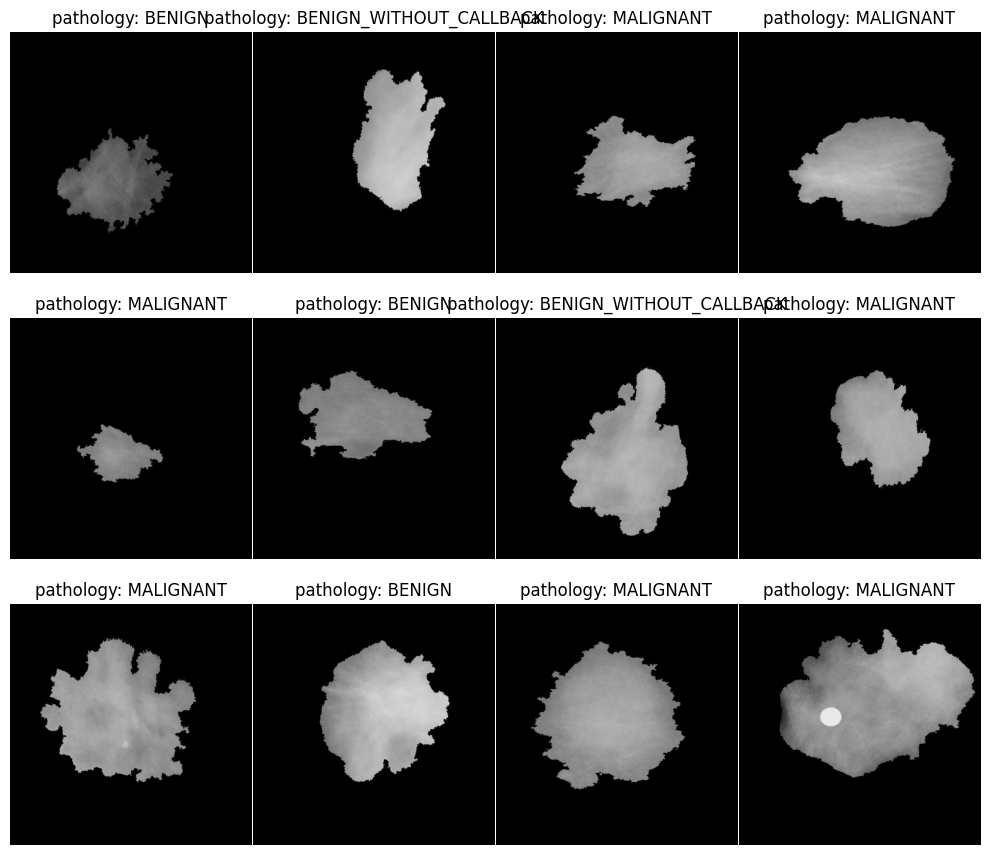

In [89]:
# # create function to display images
# # deleted not in usage
# def display_images(dataframe, number, rows, cols, save_path=None):
#     """displays images in the dataset"""
#     # create figure and axes with reduced spacing
#     fig, axes = plt.subplots(rows, cols, figsize=(10, 10), tight_layout={'w_pad': 0.1, 'h_pad': 0.1})

#     # Get a random sample of indices
#     random_indices = random.sample(range(len(dataframe)), number)

#     # Loop through rows and display images
#     for row_index in range(rows):
#         for col_index in range(cols):
#             index = row_index * cols + col_index
#             if index < number:  # Check if there are still images to display
#                 row = dataframe.iloc[random_indices[index]]
#                 image_path = row['File_Paths']

#                 # Check if image path is not missing and file exists
#                 if pd.notna(image_path) and os.path.exists(image_path):
#                     image = cv2.imread(image_path)
#                     ax = axes[row_index, col_index]
#                     ax.imshow(image, cmap='gray')
#                     ax.set_title(f"pathology: {row['pathology']}")
#                 else:
#                     # Placeholder for missing image
#                     ax = axes[row_index, col_index]
#                     ax.text(0.5, 0.5, "Missing Image", ha='center', va='center', fontsize=10, color='red')

#                 ax.axis('off')

#     # Save the figure in PDF format with 1000 dpi
#     if save_path:
#         plt.savefig(save_path, dpi=1000, format='pdf')

#     plt.show()

# # Display and save 12 randomly picked images
# print('Randomly Picked Images:\n')
# display_images(df, 12, 3, 4, save_path='randomly_picked_images.pdf')

# process and model construction

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
import torchvision.models as models
from torchvision.models import ResNet50_Weights

# from torchsummary import summary

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Define the additional convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, padding=1),  # Change input channels to 1
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.1),
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.1),
            # nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.1),
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(0.1),
            nn.Conv2d(3, 3, kernel_size=1),  # Change to 3 output channels to match Xception input
            nn.LeakyReLU(0.1)
        )
        
#         # Load the pretrained Xception model
#         self.feature_extractor = timm.create_model('legacy_xception', pretrained=True)
        
#         # Remove the last two layers of the Xception model
#         self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-2])


        # load resnet pretrained model
        self.feature_extractor = models.resnet50(weights=ResNet50_Weights.DEFAULT)

          # Remove the last fully connected layer of ResNet-50
        self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-1])

#         self.feature_extractor = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        
#         # Remove the last fully connected layer of DenseNet-121
#         self.feature_extractor = nn.Sequential(*list(self.feature_extractor.children())[:-1])
        
        # Add the desired layers
        self.global_pooling = nn.AdaptiveAvgPool2d(1)  # Global average pooling

        self.fc1 = nn.Linear(2048, 512) # For resnet50 and Xception

        self.relu = nn.ReLU()  # Changed LeakyReLU to ReLU
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        # Forward pass through the convolutional layers
        x = self.conv_layers(x)
        # print("After conv_layers shape:", x.shape)
        
        # Forward pass through the feature extractor
        x = self.feature_extractor(x)
        
        # Forward pass through the added layers
        x = self.global_pooling(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)  # Moved dropout after ReLU in fc2
        x = self.fc3(x)
        x = torch.sigmoid(x)
        
        return x

# Create an instance of the model
model = CustomModel()

# Print model summary
# print(model)

In [18]:
# Create an instance of the model
# model = CustomDenseNetModel()

# Example input tensor
input_example = torch.randn(32, 1, 598, 598)  # Batch size of 32, 3 channels, 224x224 image

# Forward pass
output_example = model(input_example)
print("Model input shape:", input_example.shape, "output shape:", output_example.shape)

Model input shape: torch.Size([32, 1, 598, 598]) output shape: torch.Size([32, 1])


In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Map labels to binary values
label_mapping = {'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0, 'MALIGNANT': 1}
df['label'] = df['pathology'].map(label_mapping)

In [19]:
df.head(2)

,File_Paths,ID1,pathology,label
0,content/all_598_augmented/_content_roi_train_M...,_content_roi_train_Mass-Training_P_00517_LEFT_...,BENIGN_WITHOUT_CALLBACK,0
1,content/all_598_augmented/_content_roi_train_M...,_content_roi_train_Mass-Training_P_01149_RIGHT...,MALIGNANT,1


In [20]:
def check_filename(filename):
    basename = os.path.basename(filename)
    return basename.endswith('1-1.png') or basename.endswith('1-2.png')

# Apply the function to filter rows
original_df = df[df['File_Paths'].apply(check_filename)]

In [21]:
len(original_df)

1696

In [109]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets
train_data, temp_data = train_test_split(original_df, test_size=0.2)
# train_data, temp_data = train_test_split(original_df, test_size=0.2, random_state=42)

In [123]:
train_data.to_csv('train_data_resnet_224.csv', index=False)

In [110]:
# Function to replicate rows and modify File_Paths
def replicate_rows(df, n_replicates):
    # Create an empty list to collect new rows
    new_rows = []
    
    # Iterate over each row in the original DataFrame
    for _, row in df.iterrows():
        # Add the original row once
        new_rows.append(row)
        
        # Add replicated rows with modified File_Paths
        for i in range(1, n_replicates + 1):
            new_row = row.copy()
            new_row['File_Paths'] = new_row['File_Paths'].replace('.png', f'_{i}.png')
            new_rows.append(new_row)
    
    # Convert list of rows to DataFrame
    return pd.DataFrame(new_rows)

# Replicate each row 5 times with modified File_Paths
train_data_augmented = replicate_rows(train_data, 5)

In [111]:
len(train_data_augmented)

8136

In [52]:
train_data_augmented.head(2)

,File_Paths,ID1,pathology,label
4901,content/all_598_augmented/_content_roi_test_Ma...,_content_roi_test_Mass-Test_P_00482_LEFT_MLO_1...,BENIGN,0
4901,content/all_598_augmented/_content_roi_test_Ma...,_content_roi_test_Mass-Test_P_00482_LEFT_MLO_1...,BENIGN,0


In [112]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]  # Assuming the image paths are in the first column
        image = Image.open(img_name)  # Open image without converting to 'L'
        image = np.array(image)  # Convert image to numpy array
        image = image.astype(np.float32)  # Convert to float32
        
        label = self.data.iloc[idx, 3]  # Assuming the labels are in the fourth column
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
  
# Define the transformation pipeline
transform_ = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Lambda(lambda x: x / 65535.0),  # Normalize tensor by dividing by 65535.0
    # transforms.CenterCrop(299),
    # transforms.Resize((299, 299))  # Ensure the final size is 448x448
    # transforms.CenterCrop(448),  # Center crop the image to 448x448
    # transforms.Resize((448, 448))  # Ensure the final size is 448x448
    transforms.CenterCrop(224),
    transforms.Resize((224, 224))  # Ensure the final size is 448x448

])

In [113]:
# Split the train set into train and validation sets
val_data, test_data = train_test_split(temp_data, test_size=1/2)
# val_data, test_data = train_test_split(temp_data, test_size=1/2, random_state=42)

# Create datasets and dataloaders for train, validation, and test sets
train_dataset_ = CustomDataset(train_data_augmented, transform=transform_)
train_loader_ = DataLoader(train_dataset_, batch_size=32, shuffle=True)

val_dataset = CustomDataset(val_data, transform=transform_)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No need to shuffle validation data

test_dataset = CustomDataset(test_data, transform=transform_)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No need to shuffle test data

In [124]:
val_data.to_csv('val_data_resnet_224.csv', index=False)
test_data.to_csv('test_data_resnet_224.csv', index=False)

In [115]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.BCELoss()  # Use binary cross-entropy loss function since the labels are binary
optimizer = optim.Adam(model.parameters(), lr=0.000003)  # resnet, Use Adam optimizer, which automatically adjusts the learning rate
# optimizer = optim.Adam(model.parameters(), lr=0.000002) #xception and resnet

# Move the model and data to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()  # Set the model to train mode
    running_loss = 0.0
    total_correct = 0
    total_samples = 0
    
    # Inside the training loop
    for images, labels in train_loader_:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs.squeeze(), labels.float())  # Squeeze to remove extra dimension

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        predicted_labels = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification
        predicted_labels_int = predicted_labels.view(-1).long()
        total_correct += (predicted_labels_int == labels).sum().item()
        total_samples += labels.size(0)
          
    # Calculate accuracy and loss for training set
    train_accuracy = total_correct / total_samples
    train_loss = running_loss / len(train_loader_)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0
    
    with torch.no_grad():  # No need to calculate gradients during validation
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)  # Move data to GPU

            # Forward pass
            val_outputs = model(val_images)

            # Calculate loss
            val_loss = criterion(val_outputs.squeeze(), val_labels.float())  # Squeeze to remove extra dimension
            val_running_loss += val_loss.item()

            # Calculate accuracy
            val_predicted_labels = (val_outputs > 0.5).float()  # Threshold at 0.5 for binary classification
            val_predicted_labels_int = val_predicted_labels.view(-1).long()
            val_total_correct += (val_predicted_labels_int == val_labels).sum().item()
            val_total_samples += val_labels.size(0)

    # Calculate accuracy and loss for validation set
    val_accuracy = val_total_correct / val_total_samples
    val_loss = val_running_loss / len(val_loader)

    # Print the training and validation results for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f},  Training Accuracy: {train_accuracy:.4f},Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # # Save model checkpoints for the last 10 epochs
    if epoch >= num_epochs - 10:
        checkpoint_name = f'model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), checkpoint_name)
        print(f"Checkpoint saved: {checkpoint_name}")

Epoch [1/20], Training Loss: 0.6911,  Training Accuracy: 0.5483,Validation Loss: 0.6912, Validation Accuracy: 0.5000
Epoch [2/20], Training Loss: 0.6867,  Training Accuracy: 0.5766,Validation Loss: 0.6865, Validation Accuracy: 0.5176
Epoch [3/20], Training Loss: 0.6796,  Training Accuracy: 0.5956,Validation Loss: 0.6764, Validation Accuracy: 0.5647
Epoch [4/20], Training Loss: 0.6673,  Training Accuracy: 0.6104,Validation Loss: 0.6620, Validation Accuracy: 0.5588
Epoch [5/20], Training Loss: 0.6526,  Training Accuracy: 0.6265,Validation Loss: 0.6409, Validation Accuracy: 0.6000
Epoch [6/20], Training Loss: 0.6375,  Training Accuracy: 0.6337,Validation Loss: 0.6334, Validation Accuracy: 0.5882
Epoch [7/20], Training Loss: 0.6274,  Training Accuracy: 0.6373,Validation Loss: 0.6269, Validation Accuracy: 0.6176
Epoch [8/20], Training Loss: 0.6176,  Training Accuracy: 0.6474,Validation Loss: 0.6227, Validation Accuracy: 0.6059
Epoch [9/20], Training Loss: 0.6107,  Training Accuracy: 0.6492,

KeyboardInterrupt: 

In [117]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# # Assuming you have defined your device as 'cuda' if available, else 'cpu'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the best model state dictionary
model.load_state_dict(torch.load('model_epoch_14.pth'))

# Set the model to evaluation mode
model.eval()

# Send the model to the same device as the input data
# model.to(device)

# Lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Loop through the test dataset
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)

        # Forward pass
        outputs = model(test_images)

        # Calculate predicted probabilities
        predicted_probs.extend(outputs.cpu().numpy())

        # Convert labels to numpy array and append to true_labels list
        true_labels.extend(test_labels.cpu().numpy())

# Convert true_labels and predicted_probs to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

# Calculate predicted labels
predicted_labels = (predicted_probs > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
roc_auc = roc_auc_score(true_labels, predicted_probs)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6765
Precision: 0.6562
Recall: 0.5600
ROC AUC: 0.7269
F1 Score: 0.6043


In [118]:
import numpy as np

# Define the iteration
n_iterations = 1000  # Could be adjusted based on your interest

# Define empty [] to store the results
accuracy_bootstrap = []
precision_bootstrap = []
recall_bootstrap = []
f1_bootstrap = []
roc_auc_bootstrap = []

# Run bootstrap and save the result
for _ in range(n_iterations):
    # Generate samples
    bootstrap_indices = np.random.choice(len(true_labels), size=len(true_labels), replace=True)
    bootstrap_true_labels = true_labels[bootstrap_indices]
    bootstrap_predicted_labels = predicted_labels[bootstrap_indices]
    bootstrap_predicted_probs = predicted_probs[bootstrap_indices]

    # Calculate the results
    bootstrap_accuracy = accuracy_score(bootstrap_true_labels, bootstrap_predicted_labels)
    bootstrap_precision = precision_score(bootstrap_true_labels, bootstrap_predicted_labels)
    bootstrap_recall = recall_score(bootstrap_true_labels, bootstrap_predicted_labels)
    bootstrap_f1 = f1_score(bootstrap_true_labels, bootstrap_predicted_labels)
    bootstrap_roc_auc = roc_auc_score(bootstrap_true_labels, bootstrap_predicted_probs)

    # Add the reuslts to the defined []
    accuracy_bootstrap.append(bootstrap_accuracy)
    precision_bootstrap.append(bootstrap_precision)
    recall_bootstrap.append(bootstrap_recall)
    f1_bootstrap.append(bootstrap_f1)
    roc_auc_bootstrap.append(bootstrap_roc_auc)

# Calculate 95% CI
accuracy_ci_bootstrap = np.percentile(accuracy_bootstrap, [2.5, 97.5])
precision_ci_bootstrap = np.percentile(precision_bootstrap, [2.5, 97.5])
recall_ci_bootstrap = np.percentile(recall_bootstrap, [2.5, 97.5])
f1_ci_bootstrap = np.percentile(f1_bootstrap, [2.5, 97.5])
roc_auc_ci_bootstrap = np.percentile(roc_auc_bootstrap, [2.5, 97.5])

# Print result
print(f"95% CI for Accuracy (Bootstrap): {accuracy_ci_bootstrap}")
print(f"95% CI for Precision (Bootstrap): {precision_ci_bootstrap}")
print(f"95% CI for Recall (Bootstrap): {recall_ci_bootstrap}")
print(f"95% CI for F1 Score (Bootstrap): {f1_ci_bootstrap}")
print(f"95% CI for ROC AUC (Bootstrap): {roc_auc_ci_bootstrap}")

95% CI for Accuracy (Bootstrap): [0.60588235 0.74705882]
95% CI for Precision (Bootstrap): [0.54284504 0.77333962]
95% CI for Recall (Bootstrap): [0.4516129  0.67033972]
95% CI for F1 Score (Bootstrap): [0.50739748 0.69503546]
95% CI for ROC AUC (Bootstrap): [0.65004679 0.79650038]


In [119]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix

array([[73, 22],
       [33, 42]])

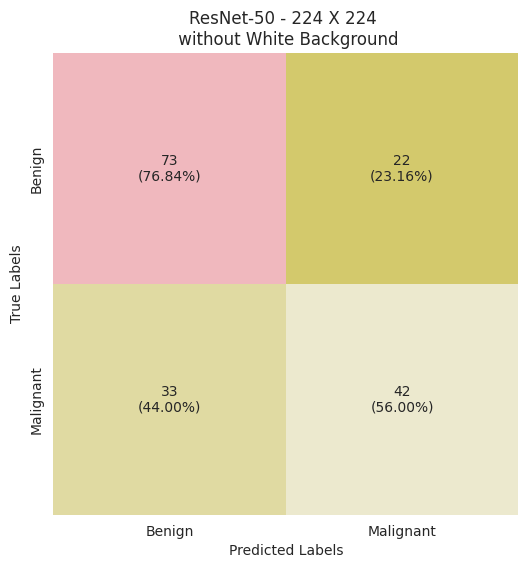

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate row-wise sums
row_sums = conf_matrix.sum(axis=1, keepdims=True)

# Calculate percentages based on row sums
conf_matrix_percent_row = conf_matrix / row_sums * 100

# Create annotations with both count and percentage values
annotations = [f"{conf_matrix[i, j]:d}\n({conf_matrix_percent_row[i, j]:.2f}%)" for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])]
annotations = np.array(annotations).reshape(conf_matrix.shape[0], conf_matrix.shape[1])

# Define custom color palette with starting color #6da9ed and ending color #eb6a4d
#colors = sns.diverging_palette(100, 5, s=80, l=60, as_cmap=True)  # 起始颜色为 #6da9ed，结束颜色为 #eb6a4d
colors = sns.diverging_palette(80, 5, s=70, l=80, as_cmap=True)


# Plot confusion matrix with annotations and custom colors
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=annotations, fmt="", cmap=colors, cbar=False)
plt.title("ResNet-50 - 224 X 224 \n without White Background")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Add custom labels
plt.xticks(ticks=[0.5, 1.5], labels=["Benign", "Malignant"])
plt.yticks(ticks=[0.5, 1.5], labels=["Benign", "Malignant"])

plt.savefig('confusion_matrix_resnet-50 - 224 X 224 without White Background.pdf', dpi=1000)
plt.show()

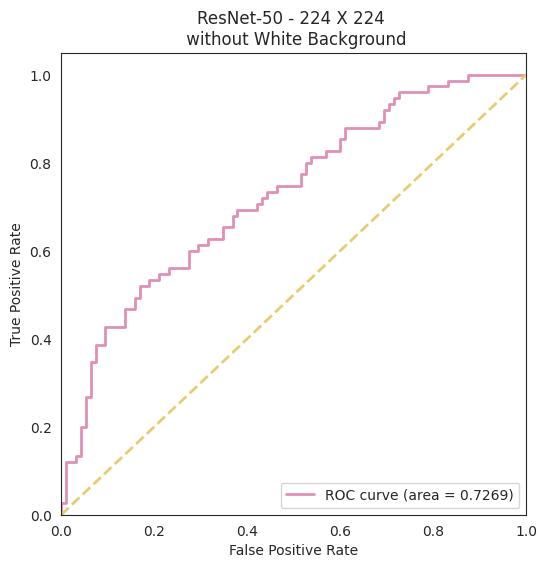

In [121]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Set Seaborn style and color palette
sns.set_style("white")
sns.set_palette(["#e090b5", "#e6cd73"])

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet-50 - 224 X 224 \n without White Background')
plt.legend(loc="lower right")

# Save the plot as PDF with 1000dpi
plt.savefig('roc_curve_resnet-50-224 - 224 X 224 without White Background.pdf', dpi=1000)
plt.show()

In [35]:
torch.cuda.empty_cache()

In [36]:
!nvidia-smi

Fri Aug  2 04:24:37 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.04   Driver Version: 525.116.04   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:00:05.0 Off |                  Off |
| 30%   29C    P2    71W / 300W |   3371MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------